In [3]:
import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr._models.base import _get_deep_layer_name

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [4]:
#transformer = "distilbert-base-cased"
#transformer = "bert-base-cased"
tf_cfg = dict(name = 'bert-base-cased', embeddings = 'bert.embeddings', layer_tmpl = 'bert.encoder.layer', layer_count = 'num_hidden_layers')
#tf_cfg = dict(name = 'roberta-base',embeddings = 'roberta.embeddings',layer_tmpl = 'roberta.encoder.layer',layer_count = 'num_hidden_layers')
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(tf_cfg['name'])
model = AutoModelForMaskedLM.from_pretrained(tf_cfg['name'])
model.eval()
model.zero_grad()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def prepare_data(sents, N):
    data = tokenizer(sents, padding=True, return_tensors="pt")
    input_tensor = data['input_ids']

    mask_indices = (input_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)
#    print(mask_indices)

    input_result = model.forward(input_tensor, data['attention_mask'], return_dict=True)

    token_logits = input_result.logits
    mask_token_logits = token_logits[(*mask_indices),]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=1)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=1)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_tensor, data['attention_mask'], top_N_tokens, mask_indices

In [6]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
#    print("INPUTS", inputs.size())
#    print("MASK", attention_mask.size(), attention_mask)
    result = model(inputs, attention_mask=attention_mask, return_dict=True)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    reps = preds.size(0) // pos[0].size(0)
    pos_r = [torch.arange(inputs.size(0)), pos[1].repeat(reps)]
#    print(pos_r)
    N_token = preds[(*pos_r),]
#    print("SHAPE", N_token.shape)
    
    return N_token

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def run_attribution_model(input_seq, attention_mask, ref_token_id, top_N_tokens, mask_indices, layer, steps):
    #interpretable_embedding = configure_interpretable_embedding_layer(model, tf_cfg['embeddings'])
    try:
        ablator = LayerIntegratedGradients(custom_forward, layer)
#        print("TOPN", top_N_tokens.size(), top_N_tokens)
        input_tensor = input_seq.repeat(top_N_tokens.size(1),1)
#        print("INPUT", input_tensor.size())
        attention_mask = attention_mask.repeat(top_N_tokens.size(1),1)
#        print("ATT", attention_mask.size(), attention_mask)
        ref_tensor = torch.tensor([ref_token_id]).expand(1,input_tensor.size(0))
#        print("REF", ref_tensor.size(), ref_tensor)
        #interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
#        print("INTER", interpretable_input_tensor.size())
        #interpretable_ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)
#        print("REF INTER", interpretable_ref_tensor.size())

        mask_indices_r = tuple(t.repeat(top_N_tokens.size(1)) for t in mask_indices)
#        print("MASK_INDICES", mask_indices, mask_indices_r)
        attributions = ablator.attribute(
                inputs=input_tensor,#interpretable_input_tensor,
                baselines=ref_token_id,#interpretable_ref_tensor,
                additional_forward_args=(attention_mask,mask_indices),
                target=top_N_tokens.flatten(),
                n_steps=steps,
        )
        attributions = summarize_attributions(attributions)
    finally:
        #remove_interpretable_embedding_layer(model, interpretable_embedding)
        pass

    return attributions

In [7]:
def build_dataframe(attributions, input_seq, attention_mask, top_N_tokens, mask_indices):

    n_sent, N = top_N_tokens.shape
    rows = []
    for n, row in enumerate(attributions):
        sent = n % n_sent
        pred_N = n // n_sent
        pred = top_N_tokens[sent, pred_N]
        for m, attribution in enumerate(row):
            if attention_mask[sent, m] == 0:
                continue
            tok = input_seq[sent, m]
            rows.append([sent, pred_N, tokenizer.decode([pred]), m, tokenizer.decode([tok]), attribution.item(), mask_indices[sent].item()])

    attr_df = pd.DataFrame(rows, columns=['sent', 'predN', 'variable', 'pos', 'token', 'value', 'mask_index'])
    return attr_df
    

In [8]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [9]:
def run_no_show(input_seq, attention_mask, preds, mask_positions, reference=[tokenizer.unk_token_id], layer=None, steps=50):
    attributions = []
    for ref in reference:
        attributions.append(
                run_attribution_model(
                        input_seq,
                        attention_mask,
                        int(ref),
                        torch.tensor(preds),
                        mask_positions,
                        layer,
                        steps,
                    )
            )
    attributions = torch.stack(attributions)
    attributions = attributions.mean(axis=0)
    df = build_dataframe(attributions, input_seq, attention_mask, np.array(predictions), mask_positions[1])
    return df

In [10]:
from IPython.display import HTML
import re

def html_for_sentences(df, mask_index, groupings):
    if len(groupings) > 1:
        output = "<div>"
        group = groupings[0]
        for g, gdf in df.groupby(group):
            output += f"<div>{group}: {g}</div><div style='padding-left:2em;'>"
            output += html_for_sentences(gdf, mask_index, groupings[1:])
            output += "</div>"
        output += "</div>"
    else:
        output = "<table>"
        for label, lvl in df.groupby(groupings[0]):
            output += f"<tr><th>{label}</th>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    pct = int(row['rel_value'] * 100)
                    g = 10 + pct
                    b = 150 + pct
                    if row['value'] >= 0:
                        r = g
                    else:
                        r = b
                    a = (row['rel_value'] / 2) + 0.3
                    color = ",".join(list(map(str, [r,g,b,a])))
                    size = (0.5 + (row['rel_value'] / 2) + 0.3) * 1.5

                    if i % len(grp) == row['mask_index']:
                        output += f"<td><span style='font-size: {size}em; text-decoration:underline;  color: rgba({color}'>{row['variable']}</span></td>"
                    else:
                        word = row['index'].strip()
                        word = re.sub(r'<', '&lt;', re.sub(r'>', '&gt;', word))
                        output += f"<td><span style='font-size: {size}em; color: rgba({color});'>{word}</span></td>"
            output += "</tr><tr><th/>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    output += f"<td style='font-size: 0.7em'>{round(row['value'],3)}</td>"
            output += "</tr>"
        output += "</table>"
    return output


In [11]:
rng = np.random.default_rng()

In [12]:
%%time
sents = [
        f"The cat from the neighbours chases a {tokenizer.mask_token}.",
        f"Giants are larger than {tokenizer.mask_token}.",
        f"The cat from the neighbours chase a {tokenizer.mask_token}.",
        f"four times twenty is {tokenizer.mask_token}.",
        f"In the mirror, a man can see {tokenizer.mask_token}."
    ]

input_tensor, attention_mask, predictions, mask_positions = prepare_data(sents, 1)

sample_count = 3
full_df = None
for sample_size in [10, 20, 30]:
    print("SAMPLE SIZE:", sample_size)
    size_df = None
    for step_count in [5, 10, 20]:
        print("STEP COUNT:", step_count)
        step_df = None
        for k in range(sample_count):
            sample_df = None
            sample = rng.integers(model.config.vocab_size, size=sample_size)
            #for i in range(getattr(model.config, tf_cfg['layer_count'])):
            for i in [0,5,10]:
                layer = getattr(_get_deep_layer_name(model, tf_cfg['layer_tmpl']), f"{i}")
                df = run_no_show(
                        input_tensor,
                        attention_mask,
                        predictions,
                        mask_positions,
                        reference=sample,
                        layer=layer,
                        steps=step_count
                    )
                df['layer'] = f"layer {i+1}"
                df['rel_value'] = (df['value'].abs() / df['value'].abs().max()).round(2)
                if sample_df is None:
                    sample_df = df
                else:
                    sample_df = pd.concat([sample_df, df])
            sample_df['sample'] = k
            sample_df['sample_list'] = "; ".join([tokenizer.decode([t]) for t in sample])
            if step_df is None:
                step_df = sample_df
            else:
                step_df = pd.concat([step_df, sample_df])
        step_df['step_count'] = step_count
        if size_df is None:
            size_df = step_df
        else:
            size_df = pd.concat([size_df, step_df])
        size_df['sample_size'] = sample_size
    if full_df is None:
        full_df = size_df
    else:
        full_df = pd.concat([full_df, size_df])
        

SAMPLE SIZE: 10
STEP COUNT: 5
STEP COUNT: 10
STEP COUNT: 20
SAMPLE SIZE: 20
STEP COUNT: 5
STEP COUNT: 10
STEP COUNT: 20
SAMPLE SIZE: 30
STEP COUNT: 5
STEP COUNT: 10
STEP COUNT: 20
CPU times: user 2h 27min 10s, sys: 1min 18s, total: 2h 28min 29s
Wall time: 37min 8s


In [15]:
full_df['layer'] = pd.Categorical(full_df['layer'], categories=[f"layer {n+1}" for n in range(12)])

In [16]:
with pd.option_context('display.max_rows', 1000):
    display(full_df)

,sent,predN,variable,pos,token,value,mask_index,layer,rel_value,sample,sample_list,step_count,sample_size
0,0,0,rabbit,0,[CLS],0.026050,9,layer 1,0.12,0,following; ##か; ‘; ##pit; technicians; perceiv...,5,10
1,0,0,rabbit,1,The,0.033473,9,layer 1,0.15,0,following; ##か; ‘; ##pit; technicians; perceiv...,5,10
2,0,0,rabbit,2,cat,0.126017,9,layer 1,0.58,0,following; ##か; ‘; ##pit; technicians; perceiv...,5,10
3,0,0,rabbit,3,from,0.012281,9,layer 1,0.06,0,following; ##か; ‘; ##pit; technicians; perceiv...,5,10
4,0,0,rabbit,4,the,-0.006214,9,layer 1,0.03,0,following; ##か; ‘; ##pit; technicians; perceiv...,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,4,0,me,7,can,0.004281,9,layer 11,0.01,2,satirical; ##iciency; am; Engineers; Reddy; ##...,20,30
47,4,0,me,8,see,0.005258,9,layer 11,0.01,2,satirical; ##iciency; am; Engineers; Reddy; ##...,20,30
48,4,0,me,9,[MASK],0.250074,9,layer 11,0.44,2,satirical; ##iciency; am; Engineers; Reddy; ##...,20,30
49,4,0,me,10,.,0.004119,9,layer 11,0.01,2,satirical; ##iciency; am; Engineers; Reddy; ##...,20,30


In [12]:
#full_df.to_parquet("20samples.parquet")

In [17]:
cosine = []
for (step_count, sample_size, sent, layer), gdf in full_df.groupby(['step_count', 'sample_size', 'sent', 'layer']):
#    print(step_count, sample_size, sent, layer)
#    display(gdf)

    for left, right in itertools.combinations(range(len(gdf['sample'].unique())), 2):
#        print(left, right)
        left_vals = np.array(gdf[gdf['sample'] == left]['value'])
        right_vals = np.array(gdf[gdf['sample'] == right]['value'])
#        print(left_vals)
#        print(right_vals)
        result = scipy.spatial.distance.cosine(
                left_vals, right_vals
            )
        cosine.append(dict(step_count=step_count, sample_size=sample_size, sent=sent, layer=layer, cosine=result))
#        print(layer, result)
cosine_df = pd.DataFrame(cosine)
cosine_df['step_count'] = pd.Categorical(cosine_df['step_count'])
cosine_df['sample_size'] = pd.Categorical(cosine_df['sample_size'])
display(cosine_df)

,step_count,sample_size,sent,layer,cosine
0,5,10,0,layer 1,0.171901
1,5,10,0,layer 1,0.033259
2,5,10,0,layer 1,0.295692
3,5,10,0,layer 6,0.005979
4,5,10,0,layer 6,0.121451
...,...,...,...,...,...
400,20,30,4,layer 6,0.011864
401,20,30,4,layer 6,0.024759
402,20,30,4,layer 11,0.000036
403,20,30,4,layer 11,0.000237


In [14]:
#cosine_df.to_parquet("20samples_cosine.parquet")

In [25]:
with pd.option_context('display.max_rows', 1000):
    display(cosine_df.groupby(["step_count", "sample_size", "layer", "sent"]).agg({'cosine': [np.mean, np.std, np.min, np.max]}))

cosine                              
                                          mean       std      amin      amax
step_count sample_size layer    sent                                        
5          10          layer 1  0     0.166951  0.131287  0.033259  0.295692
                                1     0.016608  0.009162  0.006898  0.025099
                                2     0.073415  0.029784  0.044514  0.104010
                                3     0.059308  0.041791  0.011069  0.084539
                                4     0.700108  0.495803  0.139963  1.082645
                       layer 11 0     0.000890  0.000431  0.000468  0.001330
                                1     0.000664  0.000239  0.000390  0.000824
                                2     0.001639  0.000371  0.001238  0.001969
                                3     0.000905  0.000631  0.000321  0.001575
                                4     0.000881  0.000195  0.000717  0.001097
                       layer 6  0     0.088902  0.072365  0.005979  0.139277
                                1     0.090034  0.077014  0.005750  0.156738
                                2     0.076403  0.063510  0.003619  0.120563
                                3     0.040615  0.031863  0.015632  0.076497
                                4     0.057040  0.029035  0.027064  0.085032
           20          layer 1  0     0.036433  0.019045  0.014594  0.049591
                                1     0.010637  0.003701  0.006387  0.013153
                                2     0.104907  0.066836  0.034526  0.167519
                                3     0.072636  0.049434  0.039020  0.129397
                                4     0.632703  0.481425  0.193402  1.147365
                       layer 11 0     0.000172  0.000053  0.000111  0.000207
                                1     0.000238  0.000184  0.000107  0.000449
                                2     0.000463  0.000294  0.000125  0.000650
                                3     0.002244  0.001724  0.000480  0.003924
                                4     0.000478  0.000345  0.000141  0.000830
                       layer 6  0     0.002278  0.001181  0.000981  0.003290
                                1     0.017494  0.013881  0.002802  0.030388
                                2     0.002586  0.001086  0.001522  0.003692
                                3     0.076608  0.058789  0.039268  0.144374
                                4     0.124538  0.086746  0.035965  0.209334
           30          layer 1  0     0.058952  0.036324  0.018312  0.088260
                                1     0.033469  0.025487  0.005797  0.055982
                                2     0.048499  0.025932  0.019481  0.069406
                                3     0.104289  0.074158  0.025212  0.172279
                                4     0.224062  0.118097  0.136148  0.358297
                       layer 11 0     0.001096  0.000336  0.000835  0.001474
                                1     0.000378  0.000284  0.000163  0.000700
                                2     0.001701  0.000375  0.001313  0.002060
                                3     0.000423  0.000286  0.000179  0.000738
                                4     0.000575  0.000430  0.000131  0.000991
                       layer 6  0     0.019730  0.011852  0.006644  0.029742
                                1     0.016366  0.013568  0.006353  0.031807
                                2     0.028177  0.022835  0.002649  0.046656
                                3     0.033955  0.019368  0.016161  0.054585
                                4     0.059668  0.022899  0.037905  0.083556
10         10          layer 1  0     0.313957  0.241637  0.035181  0.463396
                                1     0.160885  0.081221  0.067114  0.209209
                                2     0.130989  0.061537  0.082297  0.200152
                                3     0.133014  0.066727  0.055988  0.173185
                                4   

In [23]:
with pd.option_context('display.max_rows', 1000):
    display(cosine_df.groupby(["step_count", "sample_size", "sent", "layer"]).agg({'cosine': [np.mean, np.std, np.min, np.max]}))

cosine                              
                                          mean       std      amin      amax
step_count sample_size sent layer                                           
5          10          0    layer 1   0.166951  0.131287  0.033259  0.295692
                            layer 11  0.000890  0.000431  0.000468  0.001330
                            layer 6   0.088902  0.072365  0.005979  0.139277
                       1    layer 1   0.016608  0.009162  0.006898  0.025099
                            layer 11  0.000664  0.000239  0.000390  0.000824
                            layer 6   0.090034  0.077014  0.005750  0.156738
                       2    layer 1   0.073415  0.029784  0.044514  0.104010
                            layer 11  0.001639  0.000371  0.001238  0.001969
                            layer 6   0.076403  0.063510  0.003619  0.120563
                       3    layer 1   0.059308  0.041791  0.011069  0.084539
                            layer 11  0.000905  0.000631  0.000321  0.001575
                            layer 6   0.040615  0.031863  0.015632  0.076497
                       4    layer 1   0.700108  0.495803  0.139963  1.082645
                            layer 11  0.000881  0.000195  0.000717  0.001097
                            layer 6   0.057040  0.029035  0.027064  0.085032
           20          0    layer 1   0.036433  0.019045  0.014594  0.049591
                            layer 11  0.000172  0.000053  0.000111  0.000207
                            layer 6   0.002278  0.001181  0.000981  0.003290
                       1    layer 1   0.010637  0.003701  0.006387  0.013153
                            layer 11  0.000238  0.000184  0.000107  0.000449
                            layer 6   0.017494  0.013881  0.002802  0.030388
                       2    layer 1   0.104907  0.066836  0.034526  0.167519
                            layer 11  0.000463  0.000294  0.000125  0.000650
                            layer 6   0.002586  0.001086  0.001522  0.003692
                       3    layer 1   0.072636  0.049434  0.039020  0.129397
                            layer 11  0.002244  0.001724  0.000480  0.003924
                            layer 6   0.076608  0.058789  0.039268  0.144374
                       4    layer 1   0.632703  0.481425  0.193402  1.147365
                            layer 11  0.000478  0.000345  0.000141  0.000830
                            layer 6   0.124538  0.086746  0.035965  0.209334
           30          0    layer 1   0.058952  0.036324  0.018312  0.088260
                            layer 11  0.001096  0.000336  0.000835  0.001474
                            layer 6   0.019730  0.011852  0.006644  0.029742
                       1    layer 1   0.033469  0.025487  0.005797  0.055982
                            layer 11  0.000378  0.000284  0.000163  0.000700
                            layer 6   0.016366  0.013568  0.006353  0.031807
                       2    layer 1   0.048499  0.025932  0.019481  0.069406
                            layer 11  0.001701  0.000375  0.001313  0.002060
                            layer 6   0.028177  0.022835  0.002649  0.046656
                       3    layer 1   0.104289  0.074158  0.025212  0.172279
                            layer 11  0.000423  0.000286  0.000179  0.000738
                            layer 6   0.033955  0.019368  0.016161  0.054585
                       4    layer 1   0.224062  0.118097  0.136148  0.358297
                            layer 11  0.000575  0.000430  0.000131  0.000991
                            layer 6   0.059668  0.022899  0.037905  0.083556
10         10          0    layer 1   0.313957  0.241637  0.035181  0.463396
                            layer 11  0.000175  0.000099  0.000098  0.000286
                            layer 6   0.025437  0.013928  0.014938  0.041237
                       1    layer 1   0.160885  0.081221  0.067114  0.209209
                            layer 11

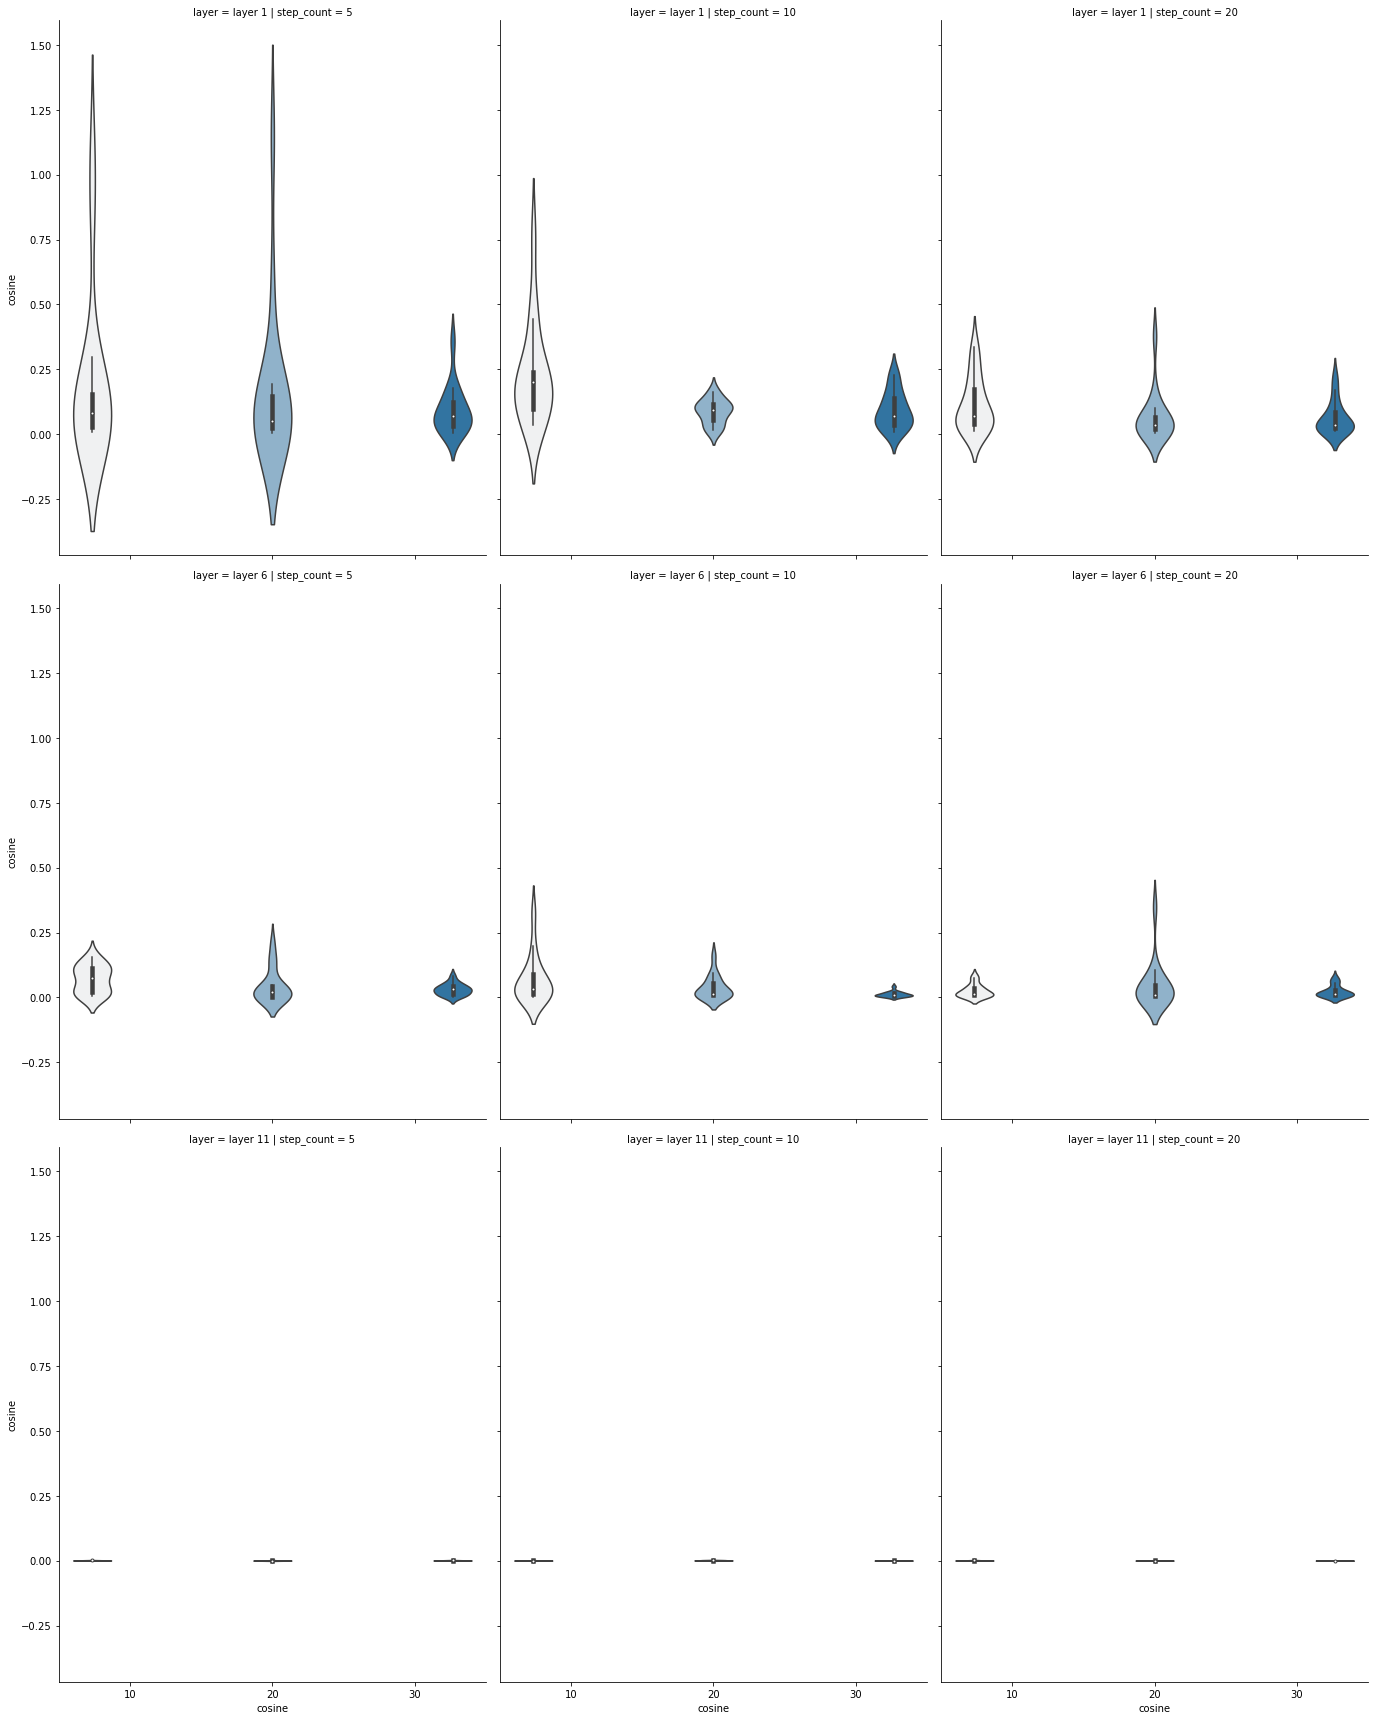

In [26]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)
g = sns.FacetGrid(cosine_df, col="step_count",  row="layer", height=8, aspect=.8, sharey=True)
g.map_dataframe(make_facet, "cosine")
plt.show()

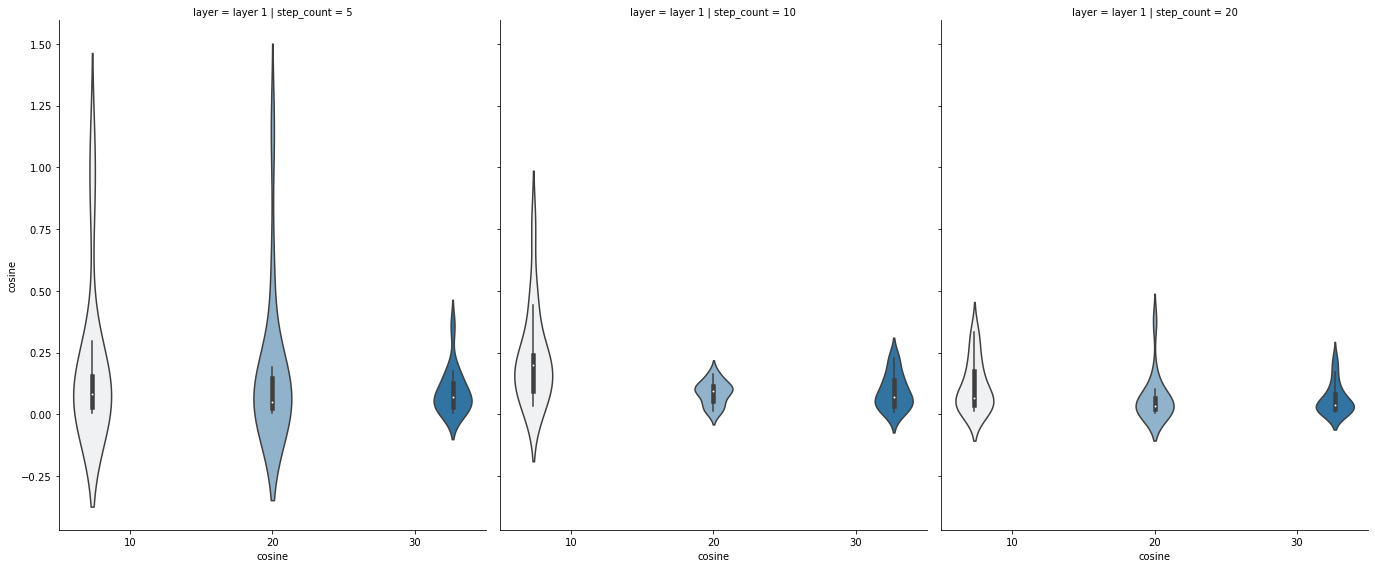

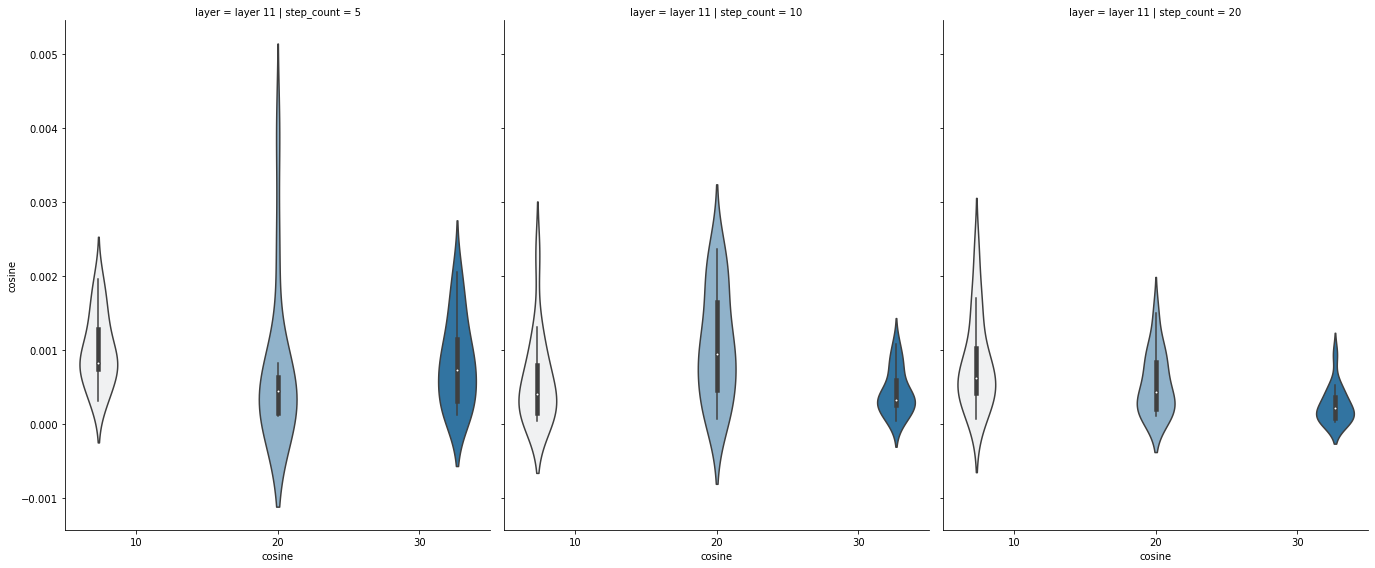

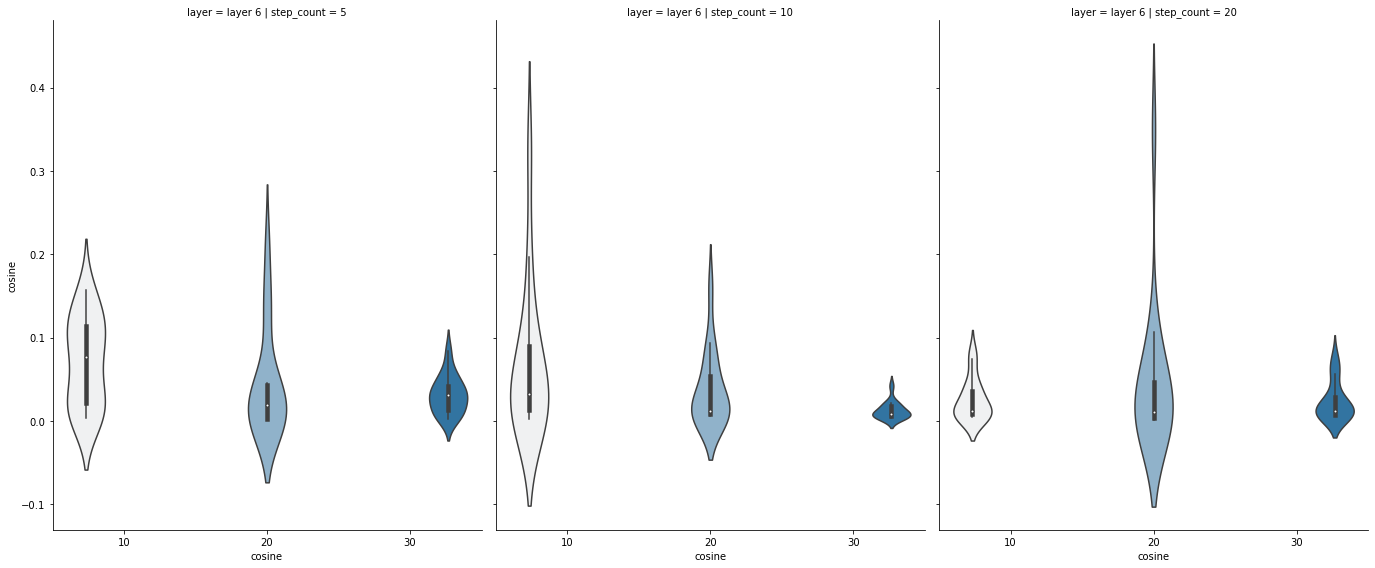

In [28]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)

for k, g in cosine_df.groupby("layer"):
    g = sns.FacetGrid(g, col="step_count",  row="layer", height=8, aspect=.8, sharey=True)
    g.map_dataframe(make_facet, "cosine")
    plt.show()

In [21]:
(full_df
     .groupby(['variable', 'sample', 'layer'])
     .agg({'value': np.max})
     .groupby(['variable', 'sample'])
     .agg({'value': [np.median, np.max, np.sum, np.std]})
)

value                              
                   median      amax       sum       std
variable sample                                        
enough   0       0.215916  0.313689  0.739095  0.058393
         1       0.218302  0.317735  0.740258  0.061874
         2       0.251379  0.326554  0.782431  0.061572
humans   0       0.365840  0.597691  1.170335  0.196571
         1       0.373281  0.563661  1.195294  0.154200
         2       0.371166  0.572381  1.179122  0.169465
me       0       0.162215  0.290581  0.541615  0.102121
         1       0.190227  0.300774  0.680249  0.064108
         2       0.207563  0.328939  0.658596  0.103940
rabbit   0       0.308844  0.522803  1.048112  0.157138
         1       0.299545  0.537875  1.075653  0.158296
         2       0.318165  0.511651  1.055580  0.145891

In [21]:
len(full_df['sample_list'].unique())

27

In [22]:
html = html_for_sentences(full_df, mask_index, ["sent", "layer", "sample"])
display(HTML(html))

NameError: name 'mask_index' is not defined

In [ ]:
html = html_for_sentences(full_df, mask_index, ["sample", "layer", "sent"])
display(HTML(html))